# Análisis de Interpretabilidad - Modelo de Predicción de Consumo de Marihuana

**Objetivo**: Analizar la interpretabilidad del modelo Random Forest final para entender:
- Variables más predictivas del consumo de marihuana
- Patrones de entorno social identificados
- Casos específicos de alta/baja probabilidad

## 1. Importar librerías y datos

In [49]:
# Librerías básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Interpretabilidad
import shap
from sklearn.inspection import permutation_importance

# Configuración de gráficos
plt.style.use('default')
sns.set_palette("husl")

print("Librerías cargadas correctamente")

Librerías cargadas correctamente


In [50]:
# Cargar datos preprocesados
X_test = np.load('../data/processed/X_test_transformed.npy')
y_test = np.load('../data/processed/y_test.npy')

# Cargar preprocessor para obtener nombres de features
preprocessor = joblib.load('../data/processed/preprocessor.joblib')

# Nombres legibles de variables
variable_names = {
    'G_01': 'Familiares Consumen Sustancias',
    'G_02': 'Amigos Consumen Sustancias',
    'G_03': 'Curiosidad por Probar',
    'G_04': 'Disposición a Consumir',
    'G_05': 'Tuvo Oportunidad de Probar',
    'G_01_A': 'Cant. Familiares que Consumen',
    'G_02_A': 'Cant. Amigos que Consumen',
    'G_06_A': 'Acceso Fácil a Marihuana',
    'G_06_B': 'Acceso Fácil a Cocaína',
    'G_06_C': 'Acceso Fácil a Basuco',
    'G_06_D': 'Acceso Fácil a Éxtasis',
    'G_07': 'Ofertas Recibidas (Último Año)',
    'G_08_A': 'Ofertas de Marihuana',
    'G_08_B': 'Ofertas de Cocaína'
}

print(f"Datos de test cargados: {X_test.shape}")
print(f"Proporción de casos positivos: {y_test.mean():.2%}")

Datos de test cargados: (4686, 14)
Proporción de casos positivos: 16.11%


## 2. Cargar modelo final

In [51]:
# Cargar metadatos del modelo
with open('../models/metadatos_modelo_final.json', 'r') as f:
    metadatos = json.load(f)

# Reconstruir el modelo RF con los hiperparámetros optimizados
from sklearn.ensemble import RandomForestClassifier

rf_params = metadatos['hiperparametros']['rf']
modelo_rf = RandomForestClassifier(
    random_state=42,
    **rf_params
)

# Cargar datos de entrenamiento para reentrenar
X_train = np.load('../data/processed/X_train_balanced.npy')
y_train = np.load('../data/processed/y_train_balanced.npy')

# Entrenar modelo
modelo_rf.fit(X_train, y_train)

# Verificar rendimiento
from sklearn.metrics import f1_score, roc_auc_score
y_pred = modelo_rf.predict(X_test)
y_proba = modelo_rf.predict_proba(X_test)[:, 1]

print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
print("\nModelo cargado y verificado")

F1 Score: 0.6617
ROC AUC: 0.9182

Modelo cargado y verificado


## 3. Feature Importance Global

In [52]:
# Obtener nombres de features transformados
feature_names = []
for transformer_name, transformer, cols in preprocessor.transformers_:
    if transformer_name == 'cat':
        # Features categóricas (one-hot encoded)
        cat_names = list(transformer.get_feature_names_out(cols))
        feature_names.extend(cat_names)
    elif transformer_name == 'num':
        # Features numéricas (escaladas)
        feature_names.extend(cols)

# Función para convertir nombres de features a nombres legibles
def get_readable_feature_name(feature_name):
    # Para variables categóricas one-hot encoded (ej: G_01_1.0)
    if '_' in feature_name and '.' in feature_name:
        base_var = '_'.join(feature_name.split('_')[:2])  # G_01
        if base_var in variable_names:
            return f"{variable_names[base_var]}"
    
    # Para variables numéricas (ej: G_01_A)
    if feature_name in variable_names:
        return variable_names[feature_name]
    
    # Si no encuentra mapeo, usar el nombre original pero más limpio
    return feature_name.replace('_', ' ').title()

# Feature Importance nativo del Random Forest
importance_rf = modelo_rf.feature_importances_

# Crear DataFrame para visualización
importance_df = pd.DataFrame({
    'feature': feature_names,
    'readable_name': [get_readable_feature_name(f) for f in feature_names],
    'importance': importance_rf
}).sort_values('importance', ascending=False)

# Mostrar top 10
print("TOP 10 VARIABLES MÁS IMPORTANTES:")
print("="*50)
for i, row in importance_df.head(10).iterrows():
    print(f"{i+1:2d}. {row['readable_name']:<35} {row['importance']:.4f}")

# Gráfico de Feature Importance con Plotly
top_15 = importance_df.head(15)

fig = go.Figure()

fig.add_trace(go.Bar(
    x=top_15['importance'],
    y=top_15['readable_name'],
    orientation='h',
    marker=dict(
        color=top_15['importance'],
        colorscale='Viridis',
        showscale=True,
        colorbar=dict(title="Importancia")
    ),
    text=[f"{val:.4f}" for val in top_15['importance']],
    textposition='outside',
    hovertemplate='<b>%{y}</b><br>Importancia: %{x:.4f}<extra></extra>'
))

fig.update_layout(
    title={
        'text': 'Top 15 Variables más Importantes - Random Forest',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 16}
    },
    xaxis_title='Importancia',
    yaxis_title='',
    height=600,
    width=900,
    yaxis={'categoryorder': 'total ascending'},
    template='plotly_white',
    margin=dict(l=200, r=50, t=80, b=50)
)

fig.show()

TOP 10 VARIABLES MÁS IMPORTANTES:
 3. Curiosidad por Probar               0.4314
 5. Tuvo Oportunidad de Probar          0.1539
 4. Disposición a Consumir              0.1170
13. Ofertas de Marihuana                0.0531
12. Ofertas Recibidas (Último Año)      0.0492
11. Acceso Fácil a Éxtasis              0.0353
 8. Acceso Fácil a Marihuana            0.0344
10. Acceso Fácil a Basuco               0.0282
 9. Acceso Fácil a Cocaína              0.0277
 2. Amigos Consumen Sustancias          0.0240


## 4. Permutation Importance

In [42]:
# Permutation Importance (más robusto)
print("Calculando Permutation Importance...")
perm_importance = permutation_importance(
    modelo_rf, X_test, y_test, 
    n_repeats=5, 
    random_state=42,
    scoring='f1'
)

# Crear DataFrame
perm_df = pd.DataFrame({
    'feature': feature_names,
    'readable_name': [get_readable_feature_name(f) for f in feature_names],
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values('importance_mean', ascending=False)

# Mostrar top 10
print("\nTOP 10 VARIABLES - PERMUTATION IMPORTANCE:")
print("="*55)
for i, row in perm_df.head(10).iterrows():
    print(f"{i+1:2d}. {row['readable_name']:<35} {row['importance_mean']:.4f} ± {row['importance_std']:.4f}")

# Gráfico con barras de error usando Plotly
top_15 = perm_df.head(15)

fig = go.Figure()

fig.add_trace(go.Bar(
    x=top_15['importance_mean'],
    y=top_15['readable_name'],
    orientation='h',
    error_x=dict(
        type='data',
        array=top_15['importance_std'],
        visible=True,
        color='rgba(0,0,0,0.3)',
        thickness=2
    ),
    marker=dict(
        color=top_15['importance_mean'],
        colorscale='Plasma',
        showscale=True,
        colorbar=dict(title="Drop en F1 Score")
    ),
    text=[f"{mean:.4f}±{std:.4f}" for mean, std in zip(top_15['importance_mean'], top_15['importance_std'])],
    textposition='outside',
    hovertemplate='<b>%{y}</b><br>Drop F1: %{x:.4f}<br>Std: %{error_x.array:.4f}<extra></extra>'
))

fig.update_layout(
    title={
        'text': 'Top 15 Variables - Permutation Importance',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 16}
    },
    xaxis_title='Importancia (F1 Score Drop)',
    yaxis_title='',
    height=600,
    width=1000,
    yaxis={'categoryorder': 'total ascending'},
    template='plotly_white',
    margin=dict(l=200, r=100, t=80, b=50)
)

fig.show()

Calculando Permutation Importance...

TOP 10 VARIABLES - PERMUTATION IMPORTANCE:
 3. Curiosidad por Probar               0.2583 ± 0.0068
 5. Tuvo Oportunidad de Probar          0.0853 ± 0.0066
 4. Disposición a Consumir              0.0527 ± 0.0032
 8. Acceso Fácil a Marihuana            0.0231 ± 0.0042
13. Ofertas de Marihuana                0.0164 ± 0.0045
12. Ofertas Recibidas (Último Año)      0.0151 ± 0.0042
11. Acceso Fácil a Éxtasis              0.0109 ± 0.0046
 2. Amigos Consumen Sustancias          0.0095 ± 0.0028
14. Ofertas de Cocaína                  0.0071 ± 0.0029
10. Acceso Fácil a Basuco               0.0059 ± 0.0039

TOP 10 VARIABLES - PERMUTATION IMPORTANCE:
 3. Curiosidad por Probar               0.2583 ± 0.0068
 5. Tuvo Oportunidad de Probar          0.0853 ± 0.0066
 4. Disposición a Consumir              0.0527 ± 0.0032
 8. Acceso Fácil a Marihuana            0.0231 ± 0.0042
13. Ofertas de Marihuana                0.0164 ± 0.0045
12. Ofertas Recibidas (Último Año) 

## 5. SHAP Analysis

In [43]:
# Inicializar SHAP explainer
print("Inicializando SHAP TreeExplainer...")
explainer = shap.TreeExplainer(modelo_rf)

# Calcular SHAP values (usar muestra para eficiencia)
sample_size = min(500, len(X_test))
sample_indices = np.random.choice(len(X_test), sample_size, replace=False)
X_sample = X_test[sample_indices]
y_sample = y_test[sample_indices]

print(f"Calculando SHAP values para {sample_size} casos...")
shap_values_raw = explainer.shap_values(X_sample)

# Debug: verificar la forma de shap_values
print(f"Forma de shap_values_raw: {np.array(shap_values_raw).shape if isinstance(shap_values_raw, list) else shap_values_raw.shape}")

# Para clasificación binaria, SHAP puede devolver (n_samples, n_features, n_classes)
if isinstance(shap_values_raw, list):
    # Caso 1: Lista con valores por clase
    shap_values = shap_values_raw[1]  # Clase positiva (consumo = 1)
    print(f"Usando clase positiva de lista. Forma final: {shap_values.shape}")
elif len(shap_values_raw.shape) == 3:
    # Caso 2: Array 3D (n_samples, n_features, n_classes)
    shap_values = shap_values_raw[:, :, 1]  # Clase positiva (consumo = 1)
    print(f"Usando clase positiva de array 3D. Forma final: {shap_values.shape}")
else:
    # Caso 3: Array 2D directo
    shap_values = shap_values_raw
    print(f"Usando valores directos. Forma: {shap_values.shape}")

# Verificar que tenemos la forma correcta
assert len(shap_values.shape) == 2, f"SHAP values debe ser 2D, pero tiene forma: {shap_values.shape}"
print(f"✓ SHAP values con forma correcta: {shap_values.shape}")

print("SHAP values calculados")

Inicializando SHAP TreeExplainer...
Calculando SHAP values para 500 casos...
Forma de shap_values_raw: (500, 14, 2)
Usando clase positiva de array 3D. Forma final: (500, 14)
✓ SHAP values con forma correcta: (500, 14)
SHAP values calculados
Forma de shap_values_raw: (500, 14, 2)
Usando clase positiva de array 3D. Forma final: (500, 14)
✓ SHAP values con forma correcta: (500, 14)
SHAP values calculados


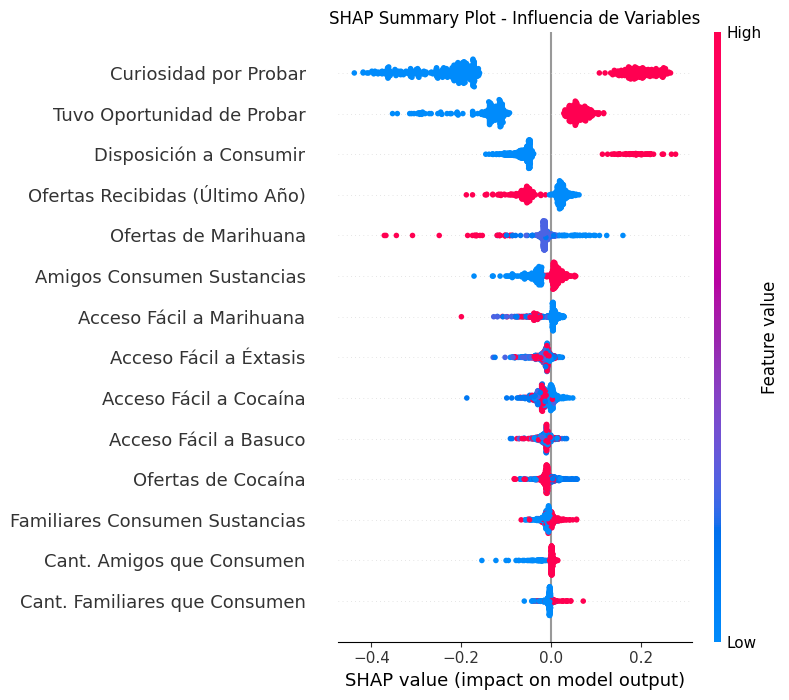

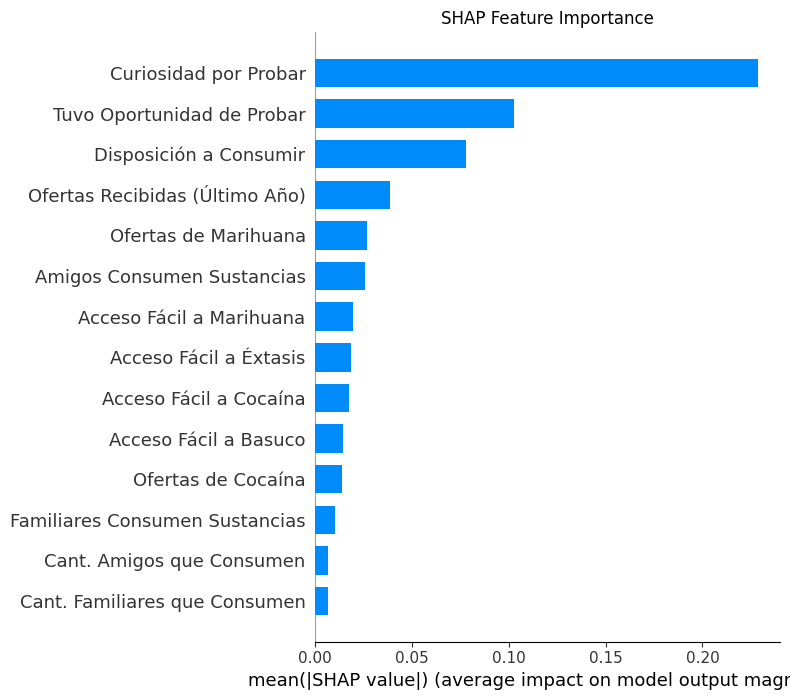

In [44]:
# Crear nombres legibles para SHAP
readable_feature_names = [get_readable_feature_name(f) for f in feature_names]

# SHAP Summary Plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample, feature_names=readable_feature_names, show=False)
plt.title('SHAP Summary Plot - Influencia de Variables')
plt.tight_layout()
plt.show()

# SHAP Feature Importance
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_sample, feature_names=readable_feature_names, plot_type="bar", show=False)
plt.title('SHAP Feature Importance')
plt.tight_layout()
plt.show()

## 6. Análisis de Casos Específicos

ANÁLISIS DE CASOS ESPECÍFICOS
Caso de MAYOR riesgo: Probabilidad = 0.998, Real = 1
Caso de MENOR riesgo: Probabilidad = 0.000, Real = 0

Falsos positivos encontrados: 44
Falsos negativos encontrados: 20

Debug - Forma de shap_values: (500, 14)
Debug - high_risk_idx: 309
Debug - Forma de shap_values[309]: (14,)
Base value: 0.49999999999999717


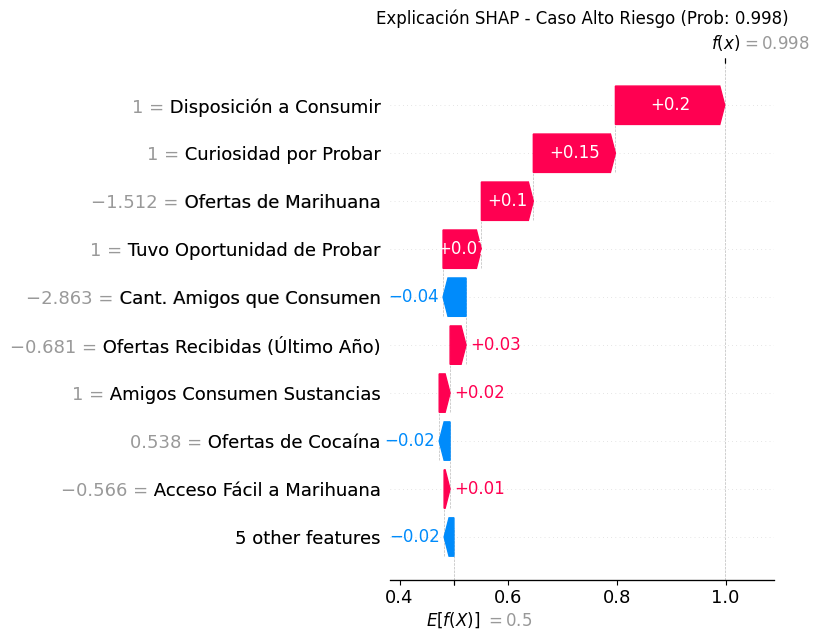


--- CASO FALSO POSITIVO ---
Probabilidad predicha: 0.669, Real: 0



--- CASO FALSO NEGATIVO ---
Probabilidad predicha: 0.437, Real: 1


In [45]:
# Predecir probabilidades para la muestra
probas_sample = modelo_rf.predict_proba(X_sample)[:, 1]

# Encontrar casos extremos
high_risk_idx = np.argmax(probas_sample)
low_risk_idx = np.argmin(probas_sample)

# Casos de falsos positivos y falsos negativos
y_pred_sample = modelo_rf.predict(X_sample)
false_positive_mask = (y_sample == 0) & (y_pred_sample == 1)
false_negative_mask = (y_sample == 1) & (y_pred_sample == 0)

print("ANÁLISIS DE CASOS ESPECÍFICOS")
print("="*50)
print(f"Caso de MAYOR riesgo: Probabilidad = {probas_sample[high_risk_idx]:.3f}, Real = {y_sample[high_risk_idx]}")
print(f"Caso de MENOR riesgo: Probabilidad = {probas_sample[low_risk_idx]:.3f}, Real = {y_sample[low_risk_idx]}")
print(f"\nFalsos positivos encontrados: {false_positive_mask.sum()}")
print(f"Falsos negativos encontrados: {false_negative_mask.sum()}")

# Función para crear gráfico SHAP con Plotly
def create_shap_plot(shap_vals, feature_names, title, prob):
    # Asegurar que shap_vals es 1D
    if len(shap_vals.shape) > 1:
        shap_vals = shap_vals.flatten()[:len(feature_names)]
    
    # Crear DataFrame para el gráfico
    shap_df = pd.DataFrame({
        'feature': feature_names[:len(shap_vals)],
        'shap_value': shap_vals,
        'abs_shap': np.abs(shap_vals)
    }).sort_values('abs_shap', ascending=False).head(10)
    
    # Colores según el signo
    colors = ['#FF6B6B' if x > 0 else '#4ECDC4' for x in shap_df['shap_value']]
    
    fig = go.Figure()
    
    fig.add_trace(go.Bar(
        x=shap_df['shap_value'],
        y=shap_df['feature'],
        orientation='h',
        marker=dict(
            color=colors,
            line=dict(color='black', width=0.5)
        ),
        text=[f"{val:.4f}" for val in shap_df['shap_value']],
        textposition='outside',
        hovertemplate='<b>%{y}</b><br>SHAP Value: %{x:.4f}<extra></extra>'
    ))
    
    # Línea vertical en cero
    fig.add_vline(x=0, line_width=2, line_color="black", opacity=0.5)
    
    fig.update_layout(
        title={
            'text': f'{title} (Prob: {prob:.3f})',
            'x': 0.5,
            'xanchor': 'center',
            'font': {'size': 14}
        },
        xaxis_title='Valor SHAP',
        yaxis_title='',
        height=500,
        width=1000,
        yaxis={'categoryorder': 'total ascending'},
        template='plotly_white',
        margin=dict(l=250, r=50, t=80, b=50),
        annotations=[
            dict(
                x=0.02, y=0.98,
                xref='paper', yref='paper',
                text='🔴 Incrementa riesgo | 🔵 Reduce riesgo',
                showarrow=False,
                font=dict(size=10),
                bgcolor="rgba(255,255,255,0.8)"
            )
        ]
    )
    
    return fig

# Debug de dimensiones antes de waterfall
print(f"\nDebug - Forma de shap_values: {shap_values.shape}")
print(f"Debug - high_risk_idx: {high_risk_idx}")
if high_risk_idx < len(shap_values):
    print(f"Debug - Forma de shap_values[{high_risk_idx}]: {shap_values[high_risk_idx].shape}")

# SHAP Analysis para caso de alto riesgo
try:
    if high_risk_idx < len(shap_values):
        # Obtener el valor base correcto
        if isinstance(explainer.expected_value, np.ndarray):
            base_value = explainer.expected_value[1] if len(explainer.expected_value) > 1 else explainer.expected_value[0]
        else:
            base_value = explainer.expected_value
        
        print(f"Base value: {base_value}")
        
        # Intentar waterfall plot
        plt.figure(figsize=(12, 8))
        explanation = shap.Explanation(
            values=shap_values[high_risk_idx], 
            base_values=base_value,
            data=X_sample[high_risk_idx],
            feature_names=readable_feature_names
        )
        
        shap.plots.waterfall(explanation, show=False)
        plt.title(f'Explicación SHAP - Caso Alto Riesgo (Prob: {probas_sample[high_risk_idx]:.3f})')
        plt.tight_layout()
        plt.show()
        
except Exception as e:
    print(f"Error en waterfall plot: {e}")
    print("Usando gráfico Plotly alternativo...")
    
    # Gráfico Plotly para caso de alto riesgo
    fig = create_shap_plot(
        shap_values[high_risk_idx], 
        readable_feature_names, 
        'Top 10 SHAP Values - Caso Alto Riesgo',
        probas_sample[high_risk_idx]
    )
    fig.show()

# Análisis adicional de un falso positivo si existe
if false_positive_mask.sum() > 0:
    fp_idx = np.where(false_positive_mask)[0][0]
    print(f"\n--- CASO FALSO POSITIVO ---")
    print(f"Probabilidad predicha: {probas_sample[fp_idx]:.3f}, Real: {y_sample[fp_idx]}")
    
    fig = create_shap_plot(
        shap_values[fp_idx], 
        readable_feature_names, 
        'Top 10 SHAP Values - Falso Positivo',
        probas_sample[fp_idx]
    )
    fig.show()

# Análisis adicional de un falso negativo si existe
if false_negative_mask.sum() > 0:
    fn_idx = np.where(false_negative_mask)[0][0]
    print(f"\n--- CASO FALSO NEGATIVO ---")
    print(f"Probabilidad predicha: {probas_sample[fn_idx]:.3f}, Real: {y_sample[fn_idx]}")
    
    fig = create_shap_plot(
        shap_values[fn_idx], 
        readable_feature_names, 
        'Top 10 SHAP Values - Falso Negativo',
        probas_sample[fn_idx]
    )
    fig.show()

## 7. Insights para Políticas Públicas

In [60]:
# Análisis de importancia por categorías
categorias = {
    'Entorno Social': ['G_01', 'G_02', 'G_01_A', 'G_02_A'],
    'Actitudes': ['G_03', 'G_04', 'G_05'],
    'Accesibilidad': ['G_06_A', 'G_06_B', 'G_06_C', 'G_06_D'],
    'Exposición': ['G_07', 'G_08_A', 'G_08_B']
}

# Calcular importancia por categoría
cat_importance = {}
for categoria, variables in categorias.items():
    # Buscar features que contengan estas variables
    cat_features = []
    for var in variables:
        cat_features.extend([f for f in feature_names if f.startswith(var)])
    
    # Sumar importancia
    total_importance = sum([importance_rf[feature_names.index(f)] for f in cat_features if f in feature_names])
    cat_importance[categoria] = total_importance

# Mostrar resultados
print("IMPORTANCIA POR CATEGORÍA DE VARIABLES")
print("="*50)
for categoria, importancia in sorted(cat_importance.items(), key=lambda x: x[1], reverse=True):
    print(f"{categoria:<20}: {importancia:.4f}")

# Gráfico de categorías con Plotly
categorias_sorted = sorted(cat_importance.items(), key=lambda x: x[1], reverse=True)
cats, imps = zip(*categorias_sorted)

# Colores personalizados para cada categoría
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

fig = go.Figure()

fig.add_trace(go.Bar(
    x=list(cats),
    y=list(imps),
    marker=dict(
        color=colors,
        line=dict(color='black', width=1)
    ),
    text=[f"{imp:.4f}" for imp in imps],
    textposition='outside',
    hovertemplate='<b>%{x}</b><br>Importancia: %{y:.4f}<extra></extra>'
))

fig.update_layout(
    title={
        'text': 'Importancia por Categoría de Variables',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 16}
    },
    xaxis_title='Categoría de Variables',
    yaxis_title='Importancia Acumulada',
    height=500,
    width=800,
    template='plotly_white',
    showlegend=False,
    margin=dict(l=50, r=50, t=80, b=50)
)

fig.show()

IMPORTANCIA POR CATEGORÍA DE VARIABLES
Actitudes           : 0.7023
Accesibilidad       : 0.1257
Exposición          : 0.1249
Entorno Social      : 0.0580


In [47]:
# Umbrales de riesgo
percentiles = [10, 25, 50, 75, 90, 95, 99]
thresholds = np.percentile(probas_sample, percentiles)

print("\nUMBRALES DE RIESGO DE CONSUMO")
print("="*40)
for p, t in zip(percentiles, thresholds):
    print(f"Percentil {p:2d}: {t:.3f}")

# Distribución de probabilidades con Plotly
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Distribución General de Probabilidades', 'Distribución por Clase Real'),
    horizontal_spacing=0.1
)

# Gráfico 1: Distribución general
fig.add_trace(
    go.Histogram(
        x=probas_sample,
        nbinsx=30,
        name='Distribución',
        marker=dict(color='lightblue', line=dict(color='black', width=1)),
        opacity=0.7
    ),
    row=1, col=1
)

# Línea del percentil 90
fig.add_vline(
    x=thresholds[percentiles.index(90)],
    line_width=2,
    line_dash="dash",
    line_color="red",
    annotation_text=f"P90: {thresholds[percentiles.index(90)]:.3f}",
    annotation_position="top right",
    row=1, col=1
)

# Gráfico 2: Distribución por clase
fig.add_trace(
    go.Histogram(
        x=probas_sample[y_sample == 0],
        nbinsx=20,
        name='No Consume',
        marker=dict(color='lightcoral', opacity=0.7),
        histnorm='density'
    ),
    row=1, col=2
)

fig.add_trace(
    go.Histogram(
        x=probas_sample[y_sample == 1],
        nbinsx=20,
        name='Consume',
        marker=dict(color='lightgreen', opacity=0.7),
        histnorm='density'
    ),
    row=1, col=2
)

fig.update_layout(
    title={
        'text': 'Análisis de Distribución de Probabilidades de Consumo',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 16}
    },
    height=500,
    width=1200,
    template='plotly_white',
    showlegend=True
)

# Actualizar etiquetas de ejes
fig.update_xaxes(title_text="Probabilidad de Consumo", row=1, col=1)
fig.update_xaxes(title_text="Probabilidad de Consumo", row=1, col=2)
fig.update_yaxes(title_text="Frecuencia", row=1, col=1)
fig.update_yaxes(title_text="Densidad", row=1, col=2)

fig.show()

# Gráfico adicional: Matriz de umbrales
threshold_df = pd.DataFrame({
    'Percentil': [f"P{p}" for p in percentiles],
    'Umbral': thresholds,
    'Descripción': [
        'Muy Bajo', 'Bajo', 'Medio-Bajo', 'Medio-Alto', 
        'Alto', 'Muy Alto', 'Crítico'
    ]
})

fig_threshold = go.Figure()

fig_threshold.add_trace(go.Bar(
    x=threshold_df['Percentil'],
    y=threshold_df['Umbral'],
    text=[f"{val:.3f}" for val in threshold_df['Umbral']],
    textposition='outside',
    marker=dict(
        color=threshold_df['Umbral'],
        colorscale='Reds',
        showscale=True,
        colorbar=dict(title="Probabilidad")
    ),
    hovertemplate='<b>%{x}</b><br>Umbral: %{y:.3f}<br>Nivel: %{text}<extra></extra>',
    customdata=threshold_df['Descripción']
))

fig_threshold.update_layout(
    title={
        'text': 'Umbrales de Riesgo por Percentiles',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 16}
    },
    xaxis_title='Percentil',
    yaxis_title='Umbral de Probabilidad',
    height=400,
    width=800,
    template='plotly_white'
)

fig_threshold.show()


UMBRALES DE RIESGO DE CONSUMO
Percentil 10: 0.000
Percentil 25: 0.001
Percentil 50: 0.029
Percentil 75: 0.432
Percentil 90: 0.833
Percentil 95: 0.917
Percentil 99: 0.991


## 8. Conclusiones

In [61]:
print("CONCLUSIONES CLAVE PARA POLÍTICAS PÚBLICAS")
print("="*60)

print("\n1. VARIABLES MÁS PREDICTIVAS:")
top_5_features = importance_df.head(5)
for i, row in top_5_features.iterrows():
    print(f"   • {row['readable_name']}")

print("\n2. CATEGORÍAS DE RIESGO POR IMPORTANCIA:")
for categoria, importancia in sorted(cat_importance.items(), key=lambda x: x[1], reverse=True):
    print(f"   • {categoria}: {importancia:.1%} de importancia total")

print("\n3. UMBRALES DE INTERVENCIÓN:")
print(f"   • Alto riesgo (P90): Probabilidad > {thresholds[percentiles.index(90)]:.3f}")
print(f"   • Riesgo muy alto (P95): Probabilidad > {thresholds[percentiles.index(95)]:.3f}")

CONCLUSIONES CLAVE PARA POLÍTICAS PÚBLICAS

1. VARIABLES MÁS PREDICTIVAS:
   • Curiosidad por Probar
   • Tuvo Oportunidad de Probar
   • Disposición a Consumir
   • Ofertas de Marihuana
   • Ofertas Recibidas (Último Año)

2. CATEGORÍAS DE RIESGO POR IMPORTANCIA:
   • Actitudes: 70.2% de importancia total
   • Accesibilidad: 12.6% de importancia total
   • Exposición: 12.5% de importancia total
   • Entorno Social: 5.8% de importancia total

3. UMBRALES DE INTERVENCIÓN:
   • Alto riesgo (P90): Probabilidad > 0.833
   • Riesgo muy alto (P95): Probabilidad > 0.917
